Obspy wasnt ported was used by a cookbook.

The modules seismic_image and seismic_wiggle use direct matrix form.

The previous cookbook example too much of a convolution to just show plotting utilities 

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [6]:
%cd fatiando

/home/andre/PycharmProjects/fatiando/fatiando


In [7]:
ls

constants.py   geothermal/  __init__.py   mesher.pyc    utils.pyc
constants.pyc  gravmag/     __init__.pyc  pinchout.bmp  _version.py
datasets.py    gridder.py   inversion/    seismic/      _version.pyc
datasets.pyc   gridder.pyc  mesher.py     utils.py      vis/


In [9]:
"""
Seismic: Synthetic pinchout tuning effect seismic display

Convolve a reflection coeficients from a velocity model with a ricker wavelet
showing the frequency tuning effect in a pinchout.
Above the lambda/4 we expected to be able to distinguish
pinchout top and base.
"""

import numpy as np
import urllib
from scipy import signal
from fatiando import utils
from fatiando.vis import mpl
# Fetch the velocity model image from somewhere
#urllib.urlretrieve(
#'https://lh4.googleusercontent.com/-LYHZJXCzeac/' +
#    'Uuwu_qiyG5I/AAAAAAAADvk/s4eWJgbdUBE/w560-h70-no/pinchout.gif',
#    'pinchout.bmp')
dt = 0.004  # sample rate
ds = 10.  # depth increment
f = 30.  # approximated frequency ricker wavelet (scipy a=1/(2.f.dt))
disc = 10  # space discretization
shp = (70, 560)
nz, nx = shp  # bellow load geologic model velociy model
vmodel = utils.fromimage('pinchout.bmp', ranges=[2500., 3500.], shape=shp)

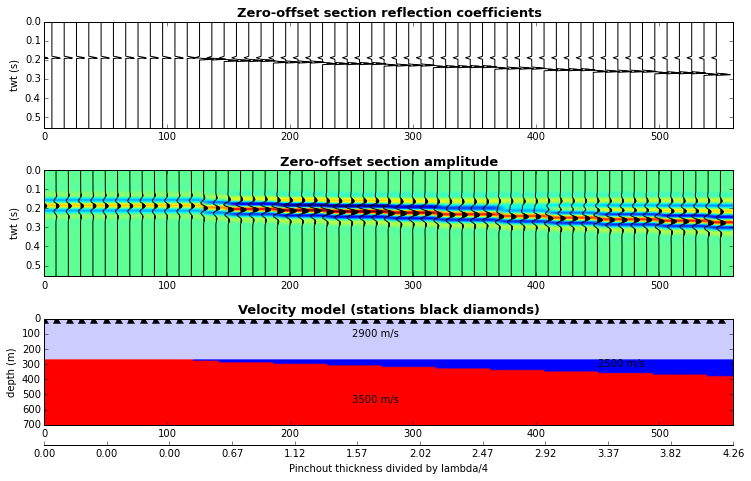

In [35]:
twti = np.cumsum(ds/vmodel, axis=0)*2  # calculate irregular sampled twt times
twt = np.arange(0, np.max(twti)+0.10, dt)  # new twt times re-sampled to 4 ms
dnx = int(nx/disc)
twtvmodel = np.zeros((len(twt), dnx))  # velocity model in time and discretized
for i in xrange(0, nx, disc):  # set the time re-sample velocity model
    twtvmodel[:, int(i/disc)] = np.interp(twt, twti[:, i], vmodel[:, i])
zimp = np.ones(twtvmodel.shape)*1000.*twtvmodel  # create impedance z = rho*v
rc = (zimp[1:]-zimp[:-1])/(zimp[1:]+zimp[:-1]) # calculate reflection coefs
fig = mpl.figure(figsize=(11, 7))  # plottings
mpl.subplots_adjust(right=0.98, left=0.11, hspace=0.4, top=0.93, bottom=0.13)
mpl.subplot2grid((3, 4), (0, 0), colspan=4)  # plot rc model
mpl.title("Zero-offset section reflection coefficients",
          fontsize=13, family='sans-serif', weight='bold')
#rcs = utils.matrix2stream(rc.transpose(), header={'delta': dt})
mpl.seismic_wiggle(rc, normalize=True, scale=1.5, ranges=[0, nx])  # rc model
wavelet = signal.ricker(255, 1/(2*f*dt))  # create wavelet
samples = signal.filtfilt(wavelet, np.ones(len(wavelet)),
                          rc, axis=0, padlen=len(twt)-2)  # convolve rc*wavelet
mpl.ylabel('twt (s)')
mpl.subplot2grid((3, 4), (1, 0), colspan=4)  # plot zero-offset traces
#traces = utils.matrix2stream(samples.transpose(), header={'delta': dt}) 
mpl.seismic_image(samples, cmap=mpl.pyplot.cm.jet, aspect='auto', ranges=[0, nx])
mpl.seismic_wiggle(samples, ranges=[0, nx], normalize=True)
mpl.ylabel('twt (s)')
mpl.title("Zero-offset section amplitude",
          fontsize=13, family='sans-serif', weight='bold')
ax = mpl.subplot2grid((3, 4), (2, 0), colspan=4)  # plot vmodel
mpl.imshow(vmodel, extent=[0, nx, nz*ds, 0],
           cmap=mpl.pyplot.cm.bwr, aspect='auto', origin='upper')
ax.autoscale(False)
mpl.ylabel('depth (m)')
stations = [[i, 0] for i in xrange(0, nx, disc)]
mpl.points(stations, '^k', size=7)  # zero-offset station points
mpl.text(250, 120, '2900 m/s')  # model velocities
mpl.text(450, 315, '2500 m/s')
mpl.text(250, 550, '3500 m/s')
# thickness by lambda/4 2nd axis
ax2 = ax.twiny()
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 20))
def thick_function_thicknessbyres(x):
    l4 = 3000/(f*4)  # average velocity resolution lambda 4
    # pinchout thickness expression
    thick = 0
    if x > 120:
        thick = 10 + (x-120)*0.2247
    return thick/l4
ax2.set_xticks(np.arange(0., nx, 50.))
ax2.set_xticklabels(
    ["%.2f" % thick_function_thicknessbyres(x) for x in xrange(0, nx, 50)])
mpl.title("Velocity model (stations black diamonds)",
          fontsize=13, family='sans-serif', weight='bold')
ax2.set_xlabel(r"Pinchout thickness divided by lambda/4")
mpl.show()

In [10]:
# include vertical line for theoretical resolution limit it is lambda/4 == 1
# also include vertical line for lambda/4 == 2